In [189]:
"""
Mixture-of-Experts pipeline 1 for LED_a
# ────────────────────────────────────────────────────────────────────────────
#  Quick description 
#
#  In this variant, “task experts” were replaced (one-vs-rest per original class) 
#  with “data experts” (one-vs-rest per cluster). After picking the initial 10 % 
#  (contiguous or random), K-Means was run to determine n_experts = number of clusters.
#  Each expert_i is then a multi class HoeffdingTree that specializes on cluster_i’s data:
#    • For any sample assigned to cluster_i, expert_i is trained to predict the label.
#    • For any sample not in cluster_i, expert_i is not trained.
# ────────────────────────────────────────────────────────────────────────────

STAGE 1 - Variant A  (first 50 % of the stream)
    - use initial 10% of the stream to cluster and define number of experts
    • split the other 40% in 80 / 20  → expert-train / expert-val
    • train n_experts one-vs-rest Hoeffding-Tree experts
    • keep all experts (we do NOT pre-discard any)

STAGE 1 - Variant B  (first 50 % of the stream)
    - use random 10% of the stream to cluster and define number of experts, remove this 10% from the data as to not contaminate
    • split the other 40% in 80 / 20  → expert-train / expert-val
    • train n_experts one-vs-rest Hoeffding-Tree experts
    • keep all experts (we do NOT pre-discard any)

STAGE 2 - Variant A (second 50 % of the stream) - hard Cross Entropy loss
    • split 80 / 20  → router-train / router-val
    • for every sample in router-train, find **which expert(s) predict correctly**
      – if ≥1 experts correct → pick the first correct ID as the target label  
      – if 0 experts correct   → skip the sample (router can’t learn from it)
    • train a n-way soft-max MLP router on those (x, expert-id) pairs
    • router-val:  router chooses an expert ► expert predicts ► measure accuracy
STAGE 2 - Variant B (second 50 % of the stream) - multi-hot BCE loss
    • split 80 / 20  → router-train / router-val
    • for every sample in router-train, find **which expert(s) predict correctly**
      – if ≥1 experts correct → pick the first correct ID as the target label  
      – if 0 experts correct   → skip the sample (router can’t learn from it)
    • train a n-way soft-max MLP router on those (x, expert-id) pairs
    • router-val:  router chooses an expert ► expert predicts ► measure accuracy
STAGE 2 - Variant C (second 50 % of the stream) - soft gating Cross Entropy loss
    • split 80 / 20  → router-train / router-val
    • for every sample in router-train, find **which expert(s) predict correctly**
      – if ≥1 experts correct → pick the first correct ID as the target label  
      – if 0 experts correct   → skip the sample (router can’t learn from it)
    • train a n-way soft-max MLP router on those (x, expert-id) pairs
    • router-val:  router chooses an expert ► expert predicts ► measure accuracy
"""

# ────────────────────────────────────────────────────────────────────────────
#  Dependencies
# ────────────────────────────────────────────────────────────────────────────

from river import tree, naive_bayes
from river.datasets import synth
import matplotlib.pyplot as plt
from river import metrics
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from collections import defaultdict
import numpy as np
import random

from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# ────────────────────────────────────────────────────────────────────────────
#  CONFIG - same as pipeline 2
# ────────────────────────────────────────────────────────────────────────────
TOTAL_SAMPLES   = 200000          # change for quick tests
TRAIN_RATIO     = 0.80
NUM_CLASSES     = 10
INPUT_DIM       = 24                 # 7 relevant + 17 irrelevant
BATCH           = 256
EPOCHS          = 5
LR              = 3e-3
SEED_STREAM     = 112
SEED_TORCH      = 42
torch.manual_seed(SEED_TORCH)
random.seed(SEED_TORCH)

In [190]:


# ────────────────────────────────────────────────────────────────────────────
#  LOAD STREAM
# ────────────────────────────────────────────────────────────────────────────
stream = list(
    synth.LEDDrift(
        seed                = SEED_STREAM,
        noise_percentage    = 0.10,
        irrelevant_features = True,
        n_drift_features    = 7
    ).take(TOTAL_SAMPLES)
)

half               = TOTAL_SAMPLES // 2
exp_cluster = TOTAL_SAMPLES // 10

# helper: dict→24-float vector
d2v = lambda d: np.fromiter(d.values(), dtype=np.float32, count=INPUT_DIM)


In [191]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 0  – CLUSTERING - random 10% vs initial 10% choice
# ────────────────────────────────────────────────────────────────────────────


# Clustering version A - using initial 10% of data to define clusters
#cluster_block = stream[:exp_cluster]
#expert_region_indices = list(range(exp_cluster, half))
#expert_block = [stream[i] for i in expert_region_indices]

# Clustering version B - using random 10% (from expert section of data) to define clusters - remove this afterwards

rand_cluster_len    = half // 10 
random.seed(SEED_TORCH)                
cluster_indices     = random.sample(range(half), rand_cluster_len)
cluster_block       = [stream[i] for i in cluster_indices]
remaining_indices   = [i for i in range(half) if i not in set(cluster_indices)]
expert_block        = [stream[i] for i in remaining_indices]

cluster_X = np.stack([d2v(x_dict) for x_dict, y in cluster_block])

In [180]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 0  – CLUSTERING - kmeans with DB metric
# ───────────────────────────────────────────────────────────────────────────-



MIN_ACCEPTABLE_K   = 3      # if DB picks < 3, switch to heuristic
FIXED_K_HEURISTIC  = int(np.ceil(np.sqrt(INPUT_DIM)))  # √d  → 5 for d=24

# ── WHITENING  (StandardScaler + PCA(whiten=True))  ───────────────────

# 1) Standardize (so each column has zero mean, unit variance)
scaler = StandardScaler().fit(cluster_X)   # <-- keep the scaler object
X_std  = scaler.transform(cluster_X)       # (n, 24) array

# 2) PCA with whitening (so covariance(X_wht) = I)
pca   = PCA(whiten=True, random_state=SEED_TORCH, svd_solver='full').fit(X_std)
X_wht = pca.transform(X_std)

# ── DB-index scan  ────────────────────────────────────────────────────

best_k, best_db = 2, np.inf
for k in range(2, NUM_CLASSES + 1):
    km = KMeans(n_clusters=k, random_state=SEED_TORCH).fit(X_wht)
    db = davies_bouldin_score(X_wht, km.labels_)   # ↓ better
    if db < best_db:
        best_k, best_db = k, db

chosen_k = best_k
reason   = f"DB optimum (k={best_k})"

# ── SAFETY NET  (ensure ≥ MIN_ACCEPTABLE_K)  ──────────────────────────
if chosen_k < MIN_ACCEPTABLE_K:
    chosen_k = max(MIN_ACCEPTABLE_K, FIXED_K_HEURISTIC)
    reason   = (f"DB gave {best_k} (<{MIN_ACCEPTABLE_K}) → "
                f"fallback to heuristic k={chosen_k}")

# ── FINAL K-MEANS FIT  ────────────────────────────────────────────────
kmeans     = KMeans(n_clusters=chosen_k, random_state=SEED_TORCH).fit(X_wht)
labels     = kmeans.labels_
n_experts  = chosen_k

print("── Stage 0  summary ──────────────────────────────────────────────")
print(f"  Selected n_experts = {n_experts}   ({reason})")
print(f"  Best DB index = {best_db:.3f}")
for cid, cnt in zip(*np.unique(labels, return_counts=True)):
    print(f"    Cluster {cid:2d}: {cnt:,} samples")
print("──────────────────────────────────────────────────────────────────\n")

── Stage 0  summary ──────────────────────────────────────────────
  Selected n_experts = 7   (DB optimum (k=7))
  Best DB index = 3.432
    Cluster  0: 2,112 samples
    Cluster  1: 2,610 samples
    Cluster  2: 3,408 samples
    Cluster  3: 3,356 samples
    Cluster  4: 3,286 samples
    Cluster  5: 2,956 samples
    Cluster  6: 2,272 samples
──────────────────────────────────────────────────────────────────



In [192]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 0  – CLUSTERING - GaussianMixture + BIC
# ───────────────────────────────────────────────────────────────────────────-


from sklearn.mixture import GaussianMixture

scaler = StandardScaler().fit(cluster_X)
X_std  = scaler.transform(cluster_X)

pca   = PCA(whiten=True, random_state=SEED_TORCH, svd_solver='full').fit(X_std)
X_wht = pca.transform(X_std)   # whitened data, shape = (n, 24)

# 0-D: GMM + BIC scan to choose k
MIN_ACCEPTABLE_K   = 4
FIXED_K_HEURISTIC  = int(np.ceil(np.sqrt(INPUT_DIM)))  # √24 → 5

bic_scores = []
for k in range(2, NUM_CLASSES + 1):
    gmm_temp = GaussianMixture(
        n_components=k,
        covariance_type="diag",
        random_state=SEED_TORCH
    ).fit(X_wht)
    bic = gmm_temp.bic(X_wht)
    bic_scores.append((k, bic))

# pick k with minimum BIC
best_k, best_bic = min(bic_scores, key=lambda item: item[1])
chosen_k = best_k
reason   = f"GMM+BIC optimal k={best_k} (BIC={best_bic:.1f})"

# 0-E: Safety net if chosen_k < MIN_ACCEPTABLE_K
if chosen_k < MIN_ACCEPTABLE_K:
    chosen_k = max(MIN_ACCEPTABLE_K, FIXED_K_HEURISTIC)
    reason   = (f"BIC gave {best_k} (<{MIN_ACCEPTABLE_K}) → "
                f"fallback to k={chosen_k}")

# 0-F: Final GMM fit with chosen_k
gmm       = GaussianMixture(
    n_components=chosen_k,
    covariance_type="diag",
    random_state=SEED_TORCH
).fit(X_wht)
labels    = gmm.predict(X_wht)    # cluster ID for each bootstrap sample
n_experts = chosen_k

print("── Stage 0 summary ─────────────────────────────────────────")
print(f"  Selected n_experts = {n_experts}   ({reason})")
uniq, cnt = np.unique(labels, return_counts=True)
for cid, ccount in zip(uniq, cnt):
    print(f"    Cluster {cid:2d}: {ccount:,} samples")
print("────────────────────────────────────────────────────────────────\n")

── Stage 0 summary ─────────────────────────────────────────
  Selected n_experts = 10   (GMM+BIC optimal k=10 (BIC=581907.7))
    Cluster  0: 1,272 samples
    Cluster  1: 514 samples
    Cluster  2: 518 samples
    Cluster  3: 560 samples
    Cluster  4: 632 samples
    Cluster  5: 559 samples
    Cluster  6: 638 samples
    Cluster  7: 4,018 samples
    Cluster  8: 584 samples
    Cluster  9: 705 samples
────────────────────────────────────────────────────────────────



In [194]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 1  – TRAIN N EXPERTS
# ────────────────────────────────────────────────────────────────────────────

n_experts = best_k

exp_train_sz       = int(len(expert_block)  * TRAIN_RATIO)
exp_train, exp_val = expert_block[:exp_train_sz], expert_block[exp_train_sz:]

experts   = {cid: tree.HoeffdingTreeClassifier() for cid in range(n_experts)}
exp_val_acc = {cid: metrics.Accuracy()           for cid in range(n_experts)}

for x_dict, y_true in exp_train:
    # 1) Raw → (1×24) → Standardize → Whiten → (1×24)
    x_raw   = d2v(x_dict).reshape(1, -1)       
    x_std   = scaler.transform(x_raw)          
    x_wht   = pca.transform(x_std)             

    # 2) Which cluster does it fall into?
    cluster_id = int(gmm.predict(x_wht)[0])

    # 3) Train expert[cluster_id] to predict the actual class y_true
    experts[cluster_id].learn_one(x_dict, y_true)

for x_dict, y_true in exp_val:
    x_raw   = d2v(x_dict).reshape(1, -1)
    x_std   = scaler.transform(x_raw)
    x_wht   = pca.transform(x_std)
    cluster_id = int(gmm.predict(x_wht)[0])

    y_pred_class = experts[cluster_id].predict_one(x_dict)
    exp_val_acc[cluster_id].update(y_true, y_pred_class)

print("\n── EXPERT VALIDATION ACCURACIES (first 50%) ─────────────")
for i in range(n_experts):
    # It is possible that cluster_i never appears in exp_val; in that case
    # exp_val_acc[i].get() will still be 0.0. We can guard against printing 0.0
    # if we also check how many val-samples fell into that cluster (counts).
    print(f" Expert {i:2d}: {exp_val_acc[i].get():.4f}")
print("")




── EXPERT VALIDATION ACCURACIES (first 50%) ─────────────
 Expert  0: 0.8176
 Expert  1: 0.9871
 Expert  2: 0.9744
 Expert  3: 0.9001
 Expert  4: 0.8968
 Expert  5: 0.9091
 Expert  6: 0.8233
 Expert  7: 0.6199
 Expert  8: 0.8254
 Expert  9: 0.7602



In [195]:

# ────────────────────────────────────────────────────────────────────────────
#  STAGE 2  – Cross Entropy loss
# ────────────────────────────────────────────────────────────────────────────

router_block = stream[half:]

rtr_train_sz       = int(len(router_block)  * TRAIN_RATIO)
rtr_train, rtr_val = router_block[:rtr_train_sz], router_block[rtr_train_sz:]

router_X, router_y = [], []


print("── SPLITS ───────────────────────────────────────────")
print(f" Total samples         : {TOTAL_SAMPLES:,}")
print(f" Expert  train / val   : {len(exp_train):,} / {len(exp_val):,}")
print(f" Router  train / val   : {len(rtr_train):,} / {len(rtr_val):,}")

for x_dict, y_true in rtr_train:
    # 1) Ask each expert to predict a class
    correct_ids = [
        i for i, e in experts.items()
        if e.predict_one(x_dict) == y_true        # “expert_i got the label right?”
    ]
    if not correct_ids:
        continue

    # 2) Use the first correct expert as the router’s target label
    router_X.append(d2v(x_dict))
    router_y.append(correct_ids[0])

router_X = np.stack(router_X)
router_y = np.array(router_y, dtype=np.int64)
print(f"Router-train usable samples            : {len(router_y):,}")

# ────────────────────────────────────────────────────────────────────────────
#  ROUTER MLP
# ────────────────────────────────────────────────────────────────────────────
class TorchDS(Dataset):
    def __init__(self,X,y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
    def __len__(self):  return len(self.X)
    def __getitem__(self,i): return self.X[i], self.y[i]

train_dl = DataLoader(TorchDS(router_X, router_y), batch_size=BATCH, shuffle=True)

class RouterMLP(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, hidden=128, out_dim=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,hidden), nn.SiLU(),
            nn.Linear(hidden,hidden), nn.SiLU(),
            nn.Linear(hidden,out_dim)
        )
    def forward(self,x): return self.net(x)

router = RouterMLP(out_dim=n_experts)
opt    = torch.optim.Adam(router.parameters(), lr=LR)
ce     = nn.CrossEntropyLoss()
print("\n── ROUTER TRAINING ACC (Second 50 %) ──────────────")
router.train()
for epoch in range(1, EPOCHS+1):
    running = 0.0
    for xb,yb in train_dl:
        opt.zero_grad()
        loss = ce(router(xb), yb)
        loss.backward(); opt.step()
        running += loss.item()*len(xb)
    print(f"Epoch {epoch}/{EPOCHS} | router-train CE: {running/len(train_dl.dataset):.4f}")

# ────────────────────────────────────────────────────────────────────────────
#  FINAL EVALUATION ON router-val
# ────────────────────────────────────────────────────────────────────────────
router.eval()
pipeline_acc = metrics.Accuracy()

with torch.no_grad():
    for x_dict, y_true in rtr_val:
        logits = router(torch.tensor(d2v(x_dict))).softmax(dim=0)
        eid    = int(torch.argmax(logits).item())
        # Now expert[eid] actually predicts a class label (0..9):
        y_pred = experts[eid].predict_one(x_dict)
        # If the chosen expert’s prediction matches y_true, pipeline is correct; else “−1”
        final  = y_pred if y_pred == y_true else -1
        pipeline_acc.update(y_true, final)

print(f"\n🏁  Pipeline accuracy on router-val slice: {pipeline_acc.get():.4f}")

── SPLITS ───────────────────────────────────────────
 Total samples         : 200,000
 Expert  train / val   : 72,000 / 18,000
 Router  train / val   : 80,000 / 20,000
Router-train usable samples            : 78,538

── ROUTER TRAINING ACC (Second 50 %) ──────────────
Epoch 1/5 | router-train CE: 0.8293
Epoch 2/5 | router-train CE: 0.6690
Epoch 3/5 | router-train CE: 0.6593
Epoch 4/5 | router-train CE: 0.6557
Epoch 5/5 | router-train CE: 0.6526

🏁  Pipeline accuracy on router-val slice: 0.7620


In [196]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 2 (multi‐label router with BCE)  
# ────────────────────────────────────────────────────────────────────────────

# 1) BUILD ROUTER‐TRAIN SET WITH MULTI‐HOT TARGETS
router_X, router_Y = [], []   # router_Y will be shape [N, n_experts]

for x_dict, y_true in rtr_train:
    # 1a) For each data‐expert i, check if it predicts y_true correctly
    multi = np.zeros(n_experts, dtype=np.float32)
    for i, e in experts.items():
        # e.predict_one(x_dict) returns a class 0..9
        if e.predict_one(x_dict) == y_true:
            multi[i] = 1.0
    # 1b) Even if multi is all zeros (no expert got it right), we keep the sample
    router_X.append(d2v(x_dict))
    router_Y.append(multi)

router_X = np.stack(router_X)       # shape = [M, 24]
router_Y = np.stack(router_Y)       # shape = [M, n_experts]

print(f"\nrouter-train samples              : {len(router_Y):,}")
print(f"positive‐label density            : {router_Y.sum() / (router_Y.size):.4f}")

# 2) DEFINE DATASET & DATALOADER AS BEFORE
class TorchDS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

# checking how many times there is overlap between expert predictions
overlap_count = 0
total_samples = router_Y.shape[0]
for multi in router_Y:
    if multi.sum() > 1:
        overlap_count += 1

print(f"Multi‐expert overlap: {overlap_count}/{total_samples} "
      f"({overlap_count/total_samples:.2%} of samples)")


train_dl = DataLoader(TorchDS(router_X, router_Y),
                      batch_size=BATCH, shuffle=True)


router = RouterMLP(in_dim=INPUT_DIM, hidden=128, out_dim=n_experts)
opt    = torch.optim.Adam(router.parameters(), lr=LR)
bce    = nn.BCEWithLogitsLoss()

router.train()
for epoch in range(1, EPOCHS + 1):
    running = 0.0
    for xb, yb in train_dl:
        opt.zero_grad()
        logits = router(xb)                           # shape = [batch, n_experts]
        loss   = bce(logits, yb)                      # multi‐label BCE
        loss.backward()
        opt.step()
        running += loss.item() * len(xb)
    print(f"Epoch {epoch}/{EPOCHS} | router‐train BCE: {running/len(train_dl.dataset):.4f}")

# 4) FINAL EVALUATION ON rtr_val (pick top‐scoring expert)
router.eval()
pipe_acc = metrics.Accuracy()

with torch.no_grad():
    for x_dict, y_true in rtr_val:
        x_vec  = torch.tensor(d2v(x_dict))
        logits = router(x_vec).sigmoid()              # shape = [n_experts]
        eid    = int(torch.argmax(logits).item())     # highest‐prob expert
        final  = experts[eid].predict_one(x_dict)     # let that expert output a class
        pipe_acc.update(y_true, final)

print(f"\n🏁  Pipeline accuracy on router‐val slice: {pipe_acc.get():.4f}")


router-train samples              : 80,000
positive‐label density            : 0.1747
Multi‐expert overlap: 61232/80000 (76.54% of samples)
Epoch 1/5 | router‐train BCE: 0.2160
Epoch 2/5 | router‐train BCE: 0.1658
Epoch 3/5 | router‐train BCE: 0.1607
Epoch 4/5 | router‐train BCE: 0.1589
Epoch 5/5 | router‐train BCE: 0.1583

🏁  Pipeline accuracy on router‐val slice: 0.7630


In [198]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 2 testing weighted voting only at inference time   
# ────────────────────────────────────────────────────────────────────────────
 

router.eval()
pipe_acc = metrics.Accuracy()

with torch.no_grad():
    for x_dict, y_true in rtr_val:
        # 1) Compute router logits → softmax probabilities
        x_vec  = torch.tensor(d2v(x_dict))             # shape = [24]
        logits = router(x_vec)                         # shape = [n_experts]
        probs  = F.softmax(logits, dim=0).numpy()       # convert to numpy array of length n_experts

        # 2) Ask each expert_i for its predicted class y_i
        #    Build a weight‐sum for each possible class (0..9)
        class_scores = np.zeros(NUM_CLASSES, dtype=np.float32)
        for i, e in experts.items():
            y_i = e.predict_one(x_dict)                 # expert_i's class prediction ∈ {0..9}
            class_scores[y_i] += probs[i]               # add router probability p_i to that class

        # 3) Final pipeline prediction = class with highest accumulated weight
        y_pred = int(np.argmax(class_scores))

        # 4) Update accuracy: if y_pred == y_true, it's correct
        pipe_acc.update(y_true, y_pred)

print(f"\n🏁  Pipeline‐weighted‐vote accuracy on router‐val: {pipe_acc.get():.4f}")


🏁  Pipeline‐weighted‐vote accuracy on router‐val: 0.7629


In [199]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 2 (Soft label training) not picking best expert, using entire distribution  
# ────────────────────────────────────────────────────────────────────────────


# 1) BUILD router_X (features) and router_pi (soft targets)
router_X, router_pi = [], []

for x_dict, y_true in rtr_train:
    # Identify which experts classify x correctly
    correct = [i for i, e in experts.items() if e.predict_one(x_dict) == y_true]
    pi = np.zeros(n_experts, dtype=np.float32)
    if correct:
        pi[np.array(correct, dtype=int)] = 1.0 / len(correct)
    # If no expert is correct, pi remains all zeros
    router_X.append(d2v(x_dict))
    router_pi.append(pi)

router_X  = np.stack(router_X)   # shape = [M, 24]
router_pi = np.stack(router_pi)  # shape = [M, n_experts]

print(f"Router‐train samples (soft‐label): {router_X.shape[0]:,}")
print(f"Avg # of experts per sample: {router_pi.sum(axis=1).mean():.2f}")

# 2) CREATE DATASET & DATALOADER
class SoftLabelRouterDS(Dataset):
    def __init__(self, X, Pi):
        self.X  = torch.tensor(X)       # float32 [M, 24]
        self.Pi = torch.tensor(Pi)      # float32 [M, n_experts]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.Pi[i]

train_dl = DataLoader(SoftLabelRouterDS(router_X, router_pi),
                      batch_size=BATCH, shuffle=True)

# 3) DEFINE Router MLP (same as before, output dim = n_experts)
import torch.nn as nn

class RouterMLP(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, hidden=128, out_dim=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden),  nn.SiLU(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

router = RouterMLP(in_dim=INPUT_DIM, hidden=128, out_dim=n_experts)
opt    = torch.optim.Adam(router.parameters(), lr=LR)

# 4) TRAIN THE ROUTER WITH SOFT‐LABEL CROSS‐ENTROPY
print("\n── ROUTER TRAINING (soft‐label CE) ─────────────────────────")
router.train()
for epoch in range(1, EPOCHS + 1):
    running = 0.0
    for xb, pi in train_dl:
        logits = router(xb)                           # [batch, n_experts]
        logp   = F.log_softmax(logits, dim=1)         # [batch, n_experts]
        loss   = - (pi * logp).sum(dim=1).mean()      # soft‐label CE
        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item() * len(xb)
    print(f"Epoch {epoch}/{EPOCHS} | router‐train soft‐CE: {running/len(train_dl.dataset):.4f}")

# 5) FINAL EVALUATION ON rtr_val (pick top‐1 from router logits)
router.eval()
pipe_acc = metrics.Accuracy()

with torch.no_grad():
    for x_dict, y_true in rtr_val:
        x_vec  = torch.tensor(d2v(x_dict))
        logits = router(x_vec).softmax(dim=0)      # [n_experts]
        eid    = int(torch.argmax(logits).item())  # top‐1 expert
        y_pred = experts[eid].predict_one(x_dict)  # expert's class prediction
        pipe_acc.update(y_true, y_pred)

print(f"\n🏁  Pipeline accuracy (soft‐label CE) on router‐val: {pipe_acc.get():.4f}")

Router‐train samples (soft‐label): 80,000
Avg # of experts per sample: 0.98

── ROUTER TRAINING (soft‐label CE) ─────────────────────────
Epoch 1/5 | router‐train soft‐CE: 1.2992
Epoch 2/5 | router‐train soft‐CE: 1.1890
Epoch 3/5 | router‐train soft‐CE: 1.1761
Epoch 4/5 | router‐train soft‐CE: 1.1709
Epoch 5/5 | router‐train soft‐CE: 1.1695

🏁  Pipeline accuracy (soft‐label CE) on router‐val: 0.7580


In [197]:
# Checking overlap between expert correct answers

from collections import Counter

overlap_counts = Counter()

for x_dict, y_true in rtr_train:
    correct_ids = [i for i, e in experts.items() if e.predict_one(x_dict) == y_true]
    overlap_counts[len(correct_ids)] += 1

total = len(rtr_train)
for k in sorted(overlap_counts):
    pct = overlap_counts[k] / total * 100
    print(f"{k:2d} correct experts → {overlap_counts[k]:5d} samples   ({pct:5.2f}%)")

 0 correct experts →  1462 samples   ( 1.83%)
 1 correct experts → 17306 samples   (21.63%)
 2 correct experts → 61232 samples   (76.54%)


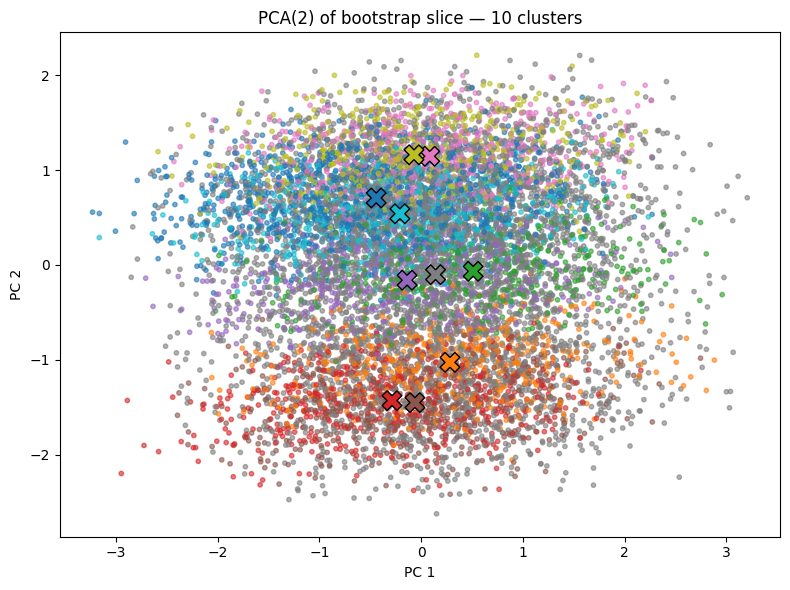

In [193]:
# PCA viz for GMM

# 1) Project your whitened points down to 2D
pca_vis = PCA(n_components=2, random_state=SEED_TORCH, svd_solver='full')
X_2d = pca_vis.fit_transform(X_wht)                    # shape = (bootstrap_size, 2)

# 2) Project the GMM centroid‐means into the same 2D
centroids_wht = gmm.means_                             # shape = (n_experts, 24)
cent_2d = pca_vis.transform(centroids_wht)             # shape = (n_experts, 2)

plt.figure(figsize=(8, 6))
# scatter the data points, coloring each by its cluster label
plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels,                 # labels is length = bootstrap_size, values in [0..n_experts-1]
    cmap="tab10", s=10, alpha=0.6
)
# scatter the centroids, one marker per cluster
plt.scatter(
    cent_2d[:, 0], cent_2d[:, 1],
    c=range(n_experts),       # exactly n_experts colors
    cmap="tab10", marker="X", s=200, edgecolor="k"
)
plt.title(f"PCA(2) of bootstrap slice — {n_experts} clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

ValueError: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 7.

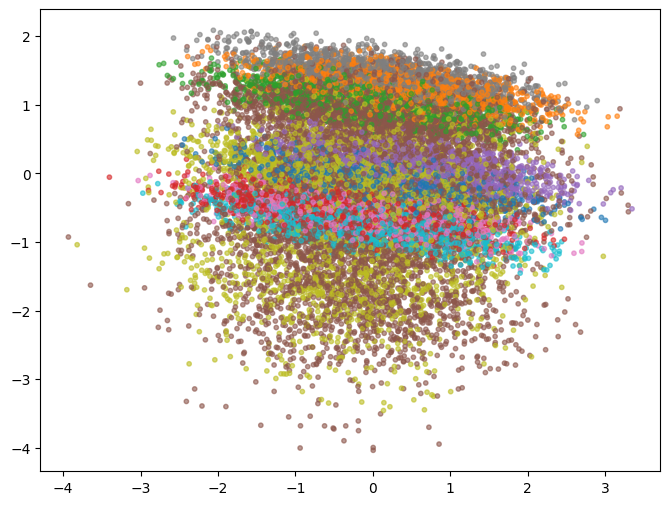

In [168]:
# PCA viz for DB
pca_vis = PCA(n_components=2, random_state=SEED_TORCH)
X_2d    = pca_vis.fit_transform(X_wht)
cent_2d = pca_vis.transform(kmeans.cluster_centers_)   # (n_experts, 2)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels, cmap="tab10", s=10, alpha=0.6,
    label="Bootstrap points"
)
plt.scatter(
    cent_2d[:, 0], cent_2d[:, 1],
    c=range(n_experts), cmap="tab10",
    marker="X", s=200, edgecolor="k",
    label="Centroids"
)
plt.title(f"PCA(2) of initial 10 % slice   —   coloured by {n_experts} clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="best", fontsize="small", frameon=True)
plt.tight_layout()
plt.show()